In [115]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)



#rides[:24*10].plot(x='dteday', y='cnt')

dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)


quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
#normalization
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    #saving mean and sd for each feature that will be normalized 
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [116]:
# Save data for approximately the last 21 days / [-x:] the last x samples to the end
test_data = data[-21*24:]

# Now remove the test data from the data set / [:-x] from begin to the first last x samples 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [117]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [118]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate

        def sigmoid(x):       
            return 1 / (1 + np.exp(-x))
        
        self.activation_function = sigmoid
         
        self.count = 0
        
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
  
        hidden_inputs = np.dot( self.weights_input_to_hidden, inputs ) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(self.weights_hidden_to_output , hidden_outputs ) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        #### Implement the backward pass here ####
        ### Backward pass ###        
        # TODO: Output error - Replace this value with your calculations.
        output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        
        # TODO: Calculate error term for the output unit
        #   output_error_term = error * output * (1 - output)
        output_errors = output_errors 
                
        # TODO: Backpropagated error - Replace these values with your calculations.
        hidden_errors = np.dot(output_errors, self.weights_hidden_to_output)  # errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs)
        
        self.weights_hidden_to_output += (self.lr * np.dot(output_errors , hidden_outputs.T))# update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T , inputs.T) * hidden_grad # update input-to-hidden weights with gradient descent step

        
        #self.weights_hidden_to_output += (self.lr *np.dot(hidden_errors, output_errors))# update hidden-to-output weights with gradient descent step
        #self.weights_input_to_hidden += self.lr * np.dot(hidden_errors.T, inputs.T) * hidden_grad # update input-to-hidden weights with gradient descent step
        
        
        self.output_errors = output_errors
        self.hidden_outputs = hidden_outputs
        self.hidden_errors = hidden_errors
        
    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2)
        
        hidden_inputs = np.dot( inputs, self.weights_input_to_hidden.T) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        

        
        # TODO: Output layer - Replace these values with your calculations.
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output.T ) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer

        
        return final_outputs

In [119]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [ ]:
import sys

### Set the hyperparameters here ###
epochs = 1000
learning_rate = 0.01
hidden_nodes = 56
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    #print(e)
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)

    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.7% ... Training loss: 1.753 ... Validation loss: 1.808

In [74]:
network.hidden_errors.shape

(10, 10)

In [62]:
network.input_nodes.shape

(1, 1)

In [79]:
(np.dot(network.output_errors, network.weights_hidden_to_output)).shape

(1, 10)

In [75]:
(network.hidden_outputs * (1 - network.hidden_outputs)).shape

(10, 1)

In [82]:
np.dot(( np.dot(network.output_errors, network.weights_hidden_to_output)) , (network.hidden_outputs * (1 - network.hidden_outputs))  ).shape

(1, 1)

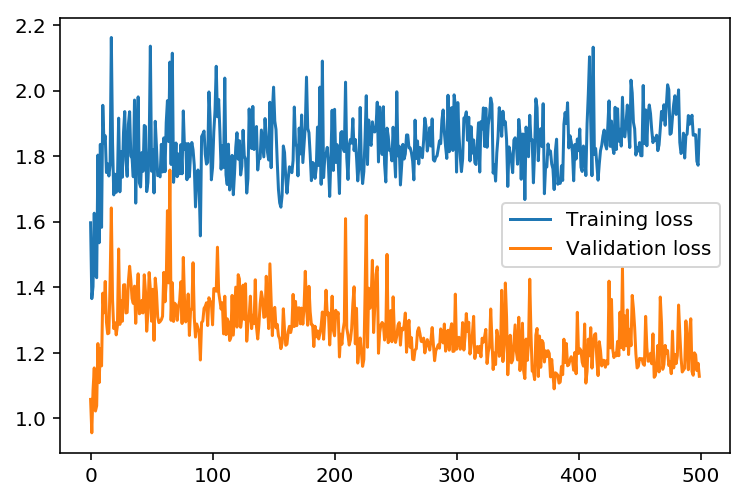

In [112]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
#plt.ylim(ymax=0.5)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

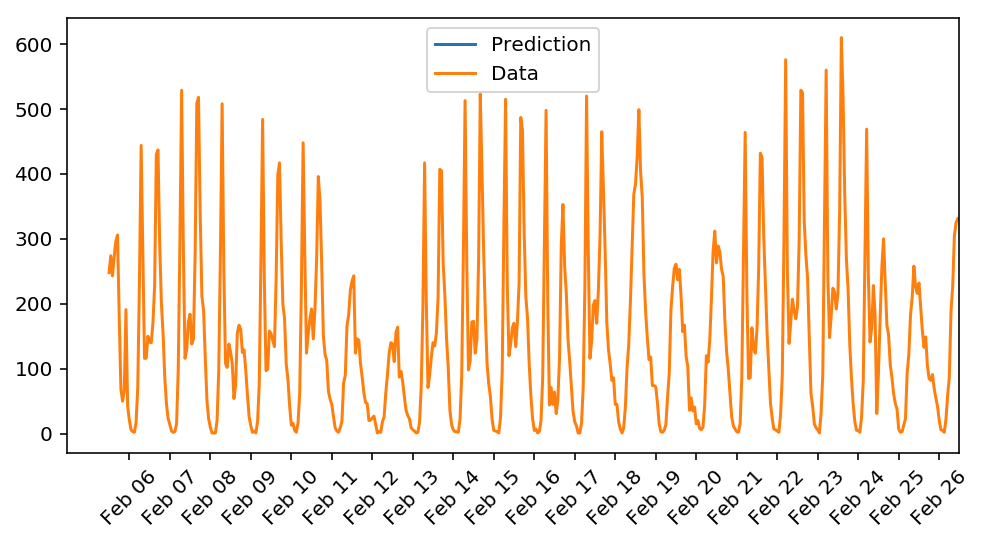

In [113]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below

## Unit tests

Run these unit tests to check the correctness of your network implementation. These tests must all be successful to pass the project.

In [114]:
import unittest

inputs = [0.5, -0.2, 0.1]
targets = [0.4]
test_w_i_h = np.array([[0.1, 0.4, -0.3], 
                       [-0.2, 0.5, 0.2]])
test_w_h_o = np.array([[0.3, -0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328, -0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014,  0.39775194, -0.29887597],
                                              [-0.20185996,  0.50074398,  0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>